In [1]:
import pandas as pd
train_data = pd.read_csv('/content/drive/MyDrive/SPH 6004/Assignment 2/Version 4/Timestep5_train_cat0.csv')
test_data = pd.read_csv('/content/drive/MyDrive/SPH 6004/Assignment 2/Version 4/Timestep5_test_cat0.csv')
# holdout_data = pd.read_csv('')

In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35700 entries, 0 to 35699
Data columns (total 70 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   id                                                               35700 non-null  int64  
 1   charttime                                                        35700 non-null  object 
 2   aniongap                                                         35700 non-null  int64  
 3   bicarbonate                                                      35700 non-null  float64
 4   bun                                                              35700 non-null  int64  
 5   calcium                                                          35700 non-null  float64
 6   chloride                                                         35700 non-null  int64  
 7   creatinine                              

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_sequences_fixed(data, timestep):
    numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
    columns_to_scale = [col for col in numeric_columns if col not in ['id', 'charttime', 'los_icu', 'icu_death', 'hour', 'icu_cat']]

    grouped_data = data.groupby('id')
    scaler = MinMaxScaler()

    time_series = []
    targets = []

    for _, group_data in grouped_data:

        scaled_data = scaler.fit_transform(group_data[columns_to_scale])

        target_data = group_data['los_icu'].iloc[-1]

        time_series.append(scaled_data)
        targets.append(target_data)
    return np.array(time_series), np.array(targets)

In [4]:
timestep=5
train_sequences, train_targets = create_sequences_fixed(train_data, timestep)
test_sequences, test_targets = create_sequences_fixed(test_data, timestep)
# holdout_sequences, holdout_targets = create_sequences_fixed(holdout_data, timestep)

In [5]:
train_sequences.shape, train_targets.shape

((7140, 5, 59), (7140,))

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

model = Sequential([
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(timestep, train_sequences.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 32)             3808      
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 32)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                        

In [7]:
print(model.layers[0].input_shape)

(None, 5, 59)


In [8]:
history = model.fit(train_sequences, train_targets, epochs=10, validation_split=0.2)

Epoch 1/10
179/179 [==============================] - 3s 7ms/step - loss: 0.4525 - mae: 0.5223 - val_loss: 0.1895 - val_mae: 0.3703
Epoch 2/10
179/179 [==============================] - 1s 4ms/step - loss: 0.1849 - mae: 0.3705 - val_loss: 0.1855 - val_mae: 0.3656
Epoch 3/10
179/179 [==============================] - 1s 4ms/step - loss: 0.1807 - mae: 0.3663 - val_loss: 0.1851 - val_mae: 0.3671
Epoch 4/10
179/179 [==============================] - 1s 5ms/step - loss: 0.1786 - mae: 0.3643 - val_loss: 0.1847 - val_mae: 0.3684
Epoch 5/10
179/179 [==============================] - 1s 4ms/step - loss: 0.1749 - mae: 0.3602 - val_loss: 0.1828 - val_mae: 0.3653
Epoch 6/10
179/179 [==============================] - 1s 4ms/step - loss: 0.1727 - mae: 0.3586 - val_loss: 0.1844 - val_mae: 0.3669
Epoch 7/10
179/179 [==============================] - 1s 3ms/step - loss: 0.1711 - mae: 0.3573 - val_loss: 0.1970 - val_mae: 0.3791
Epoch 8/10
179/179 [==============================] - 0s 3ms/step - loss: 0.

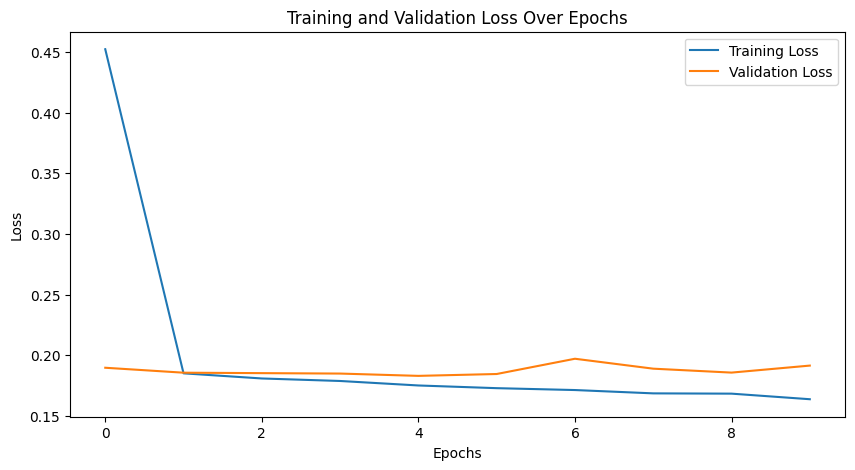

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
model.evaluate(test_sequences, test_targets)

56/56 [==============================] - 0s 6ms/step - loss: 0.1921 - mae: 0.3773


[0.19206050038337708, 0.3773250877857208]

In [11]:
test_predict = model.predict(test_sequences)
test_predict = np.round(test_predict, 2)

56/56 [==============================] - 0s 2ms/step


In [12]:
test_predict

array([[1.49],
       [1.58],
       [1.47],
       ...,
       [1.65],
       [1.54],
       [1.7 ]], dtype=float32)

In [13]:
test_targets

array([2.18, 1.52, 1.44, ..., 1.01, 1.78, 1.2 ])